In [1]:
# import basic packages needed in this study

import os
import scipy.io as sio
import pandas as pd
import numpy as np
import pickle as pk
from copy import deepcopy
from scipy.stats import invwishart, multivariate_normal, norm
from scipy.special import logsumexp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%run HBM_Gibbs_noMissing.py


### Synthesize data

Training data

In [2]:
rand_seed = 202111

N_site = 30
N_site_num = 10

mu0_true = np.array([
    [0, 0, 0], # cluster 1
    [0, 0, 0], # cluster 2
    [0, 0, 0], # cluster 3
])

C0_sig_true =  np.array([
    [1, 1, 1], # cluster 1
    [1, 1, 1], # cluster 2
    [1, 1, 1], # cluster 3
])

C0_rho_true =  np.array([
    [0, 0, 0], # cluster 1
    [0, 0, 0], # cluster 2
    [0, 0, 0], # cluster 3
])

nu0_true = np.array([8, 8, 8])

Sig0_sig_true =  np.array([
    [1, 1, 1], # cluster 1
    [1, 1, 1], # cluster 2
    [1, 1, 1], # cluster 3
])

Sig0_rho_true =  np.array([
    [0.9, -0.9, -0.9], # cluster 1
    [0, 0, -0.9], # cluster 2
    [0, 0, 0], # cluster 3
])


In [3]:
N_dim_true = len(mu0_true[0])
N_c = len(mu0_true)

# assemble C0 and Sig0

C0_true = []
for i, sig in enumerate(C0_sig_true):
    C0_true.append(np.array([
        [sig[0]**2, sig[0]*sig[1]*C0_rho_true[i][0], sig[0]*sig[2]*C0_rho_true[i][1]],
        [sig[0]*sig[1]*C0_rho_true[i][0], sig[1]**2, sig[1]*sig[2]*C0_rho_true[i][2]],
        [sig[0]*sig[2]*C0_rho_true[i][1], sig[1]*sig[2]*C0_rho_true[i][2], sig[2]**2]])
                  )
    
Sig0_true = []
for i, sig in enumerate(Sig0_sig_true):
    Sig0_true.append(4*np.array([
        [sig[0]**2, sig[0]*sig[1]*Sig0_rho_true[i][0], sig[0]*sig[2]*Sig0_rho_true[i][1]],
        [sig[0]*sig[1]*Sig0_rho_true[i][0], sig[1]**2, sig[1]*sig[2]*Sig0_rho_true[i][2]],
        [sig[0]*sig[2]*Sig0_rho_true[i][1], sig[1]*sig[2]*Sig0_rho_true[i][2], sig[2]**2]])
                  )

# generate mu, C and data for each site of each cluster
np.random.seed(rand_seed)

mu_true, C_true, x_true = [], [], []
for i, mu in enumerate(mu0_true):
    mu_true.append(multivariate_normal.rvs(mean=mu, cov=C0_true[i], size=N_site))
    C_true.append(invwishart.rvs(df=nu0_true[i], scale=Sig0_true[i], size=N_site))
    x_true.append([multivariate_normal.rvs(mean=mu_true[-1][j,:], cov=C_true[-1][j,:,:], size=N_site_num) for j in range(N_site)])
    

In [4]:
x_train_df = []
for j, val_j in enumerate(x_true):
    for i, val in enumerate(val_j):
        tmp_df = pd.DataFrame(val, index=[f'{j+1}-{i}_{x}' for x in range(val.shape[0])])
        tmp_df['label'] = f'{j+1}-{i}'
        x_train_df.append(deepcopy(tmp_df))

x_train_df = pd.concat(x_train_df, axis=0)

x_train_df


,0,1,2,label
1-0_0,-0.088594,1.841717,2.176710,1-0
1-0_1,2.125910,4.661205,-0.825885,1-0
1-0_2,0.943203,2.343626,1.683468,1-0
1-0_3,1.070558,3.601050,0.552449,1-0
1-0_4,0.438083,2.554886,1.189893,1-0
...,...,...,...,...
3-29_5,-0.229581,-2.055003,-0.816222,3-29
3-29_6,-0.064966,-1.739647,-1.807026,3-29
3-29_7,1.219555,-0.401532,-2.167396,3-29
3-29_8,1.602407,-2.209384,-2.062588,3-29


Test data

In [4]:
rand_seed_test = 20211100

N_site_test = 5
N_site_num_test = 10


In [5]:
# generate mu, C and data for each site of each cluster
np.random.seed(rand_seed_test)

mu_test, C_test, x_test = [], [], []
for i, mu in enumerate(mu0_true):
    mu_test.append(multivariate_normal.rvs(mean=mu, cov=C0_true[i], size=N_site_test))
    C_test.append(invwishart.rvs(df=nu0_true[i], scale=Sig0_true[i], size=N_site_test))
    x_test.append([multivariate_normal.rvs(mean=mu_test[-1][j,:], cov=C_test[-1][j,:,:], size=N_site_num_test) for j in range(N_site_test)])
    

In [6]:
x_test_df = []
for j, val_j in enumerate(x_test):
    for i, val in enumerate(val_j):
        tmp_df = pd.DataFrame(val, index=[f'{j+1}-{i}_{x}' for x in range(val.shape[0])])
        tmp_df['label'] = f'{j+1}-{i}'
        x_test_df.append(deepcopy(tmp_df))

x_test_df = pd.concat(x_test_df, axis=0)

x_test_df


,0,1,2,label
1-0_0,-1.497948,-0.418292,0.463722,1-0
1-0_1,-0.829829,-0.641440,-0.089269,1-0
1-0_2,0.147677,1.537730,-0.995171,1-0
1-0_3,-1.969361,-1.129831,1.067215,1-0
1-0_4,1.049042,1.124285,-1.891642,1-0
...,...,...,...,...
3-4_5,-2.940740,0.354558,-2.688002,3-4
3-4_6,-3.085574,0.823338,-1.060072,3-4
3-4_7,-0.360264,1.619905,-1.455568,3-4
3-4_8,-2.770638,1.091210,-1.460869,3-4


Save data

In [ ]:
dir_save_data = f'Data/SynData_Cluster_D{N_dim_true}_Str{rand_seed}_Ste{rand_seed_test}'
x_train_df.to_csv(f'{dir_save_data}/training_3D.csv')
x_test_df.to_csv(f'{dir_save_data}/test_3D.csv')

In [6]:
dir_save_data = f'Data/SynData_Cluster_D{N_dim_true}_Str{rand_seed}_Ste{rand_seed_test}'
os.makedirs(dir_save_data, exist_ok=True)

with open(f'{dir_save_data}/raw_data.pkl', 'wb') as f:
    pk.dump({'mu_train': mu_true, 'C_train': C_true, 'x_train': x_true, 'mu_test': mu_test, 'C_test': C_test, 'x_test': x_test}, f)
    

Extract/calculate mu_s and C_s parameters

In [8]:
%%time

tmp_list = np.array(list(range(N_dim_true)))
col_mu = [f'mu_{x+1}' for x in tmp_list]
col_sig = [f'sig_{x+1}' for x in tmp_list]
col_rho = [f'rho_{x+1}-{y+1}' for i, y in enumerate(tmp_list[1:]) for x in tmp_list[:(i+1)]]

data_Gauss_true = [pd.DataFrame() for _ in range(N_c)]
for j in range(N_c):
    for i in range(N_site):
        mu = pd.Series(mu_true[j][i,:])
        cov = C_true[j][i,:,:]
        sig = pd.Series(np.sqrt(np.diag(cov)))
        rho = pd.Series([cov[y,x]/sig[y]/sig[x] for ii, y in enumerate(tmp_list[1:]) for x in tmp_list[:(ii+1)]])
        data_Gauss_true[j] = data_Gauss_true[j].append(deepcopy(pd.Series(np.concatenate([mu, sig, rho]), name=f'{j+1}-{i}')))
    
    data_Gauss_true[j].columns = col_mu+col_sig+col_rho

data_Gauss_true

# test data
tmp_list = np.array(list(range(N_dim_true)))
col_mu = [f'mu_{x+1}' for x in tmp_list]
col_sig = [f'sig_{x+1}' for x in tmp_list]
col_rho = [f'rho_{x+1}-{y+1}' for i, y in enumerate(tmp_list[1:]) for x in tmp_list[:(i+1)]]

data_Gauss_test = [pd.DataFrame() for _ in range(N_c)]
for j in range(N_c):
    for i in range(N_site_test):
        mu = pd.Series(mu_test[j][i,:])
        cov = C_test[j][i,:,:]
        sig = pd.Series(np.sqrt(np.diag(cov)))
        rho = pd.Series([cov[y,x]/sig[y]/sig[x] for ii, y in enumerate(tmp_list[1:]) for x in tmp_list[:(ii+1)]])
        data_Gauss_test[j] = data_Gauss_test[j].append(deepcopy(pd.Series(np.concatenate([mu, sig, rho]), name=f'{j+1}-{i}')))
    
    data_Gauss_test[j].columns = col_mu+col_sig+col_rho


CPU times: user 194 ms, sys: 5.55 ms, total: 200 ms
Wall time: 195 ms


In [9]:
%%time

data_Gauss_true_est = [pd.DataFrame() for _ in range(N_c)]
for j in range(N_c):
    for i in range(N_site):
        target_data = pd.DataFrame(x_true[j][i])
        mu = target_data.mean(axis=0)
        cov = pd.DataFrame(index=target_data.columns, columns=target_data.columns)
        tmp = target_data.cov(min_periods=3)
        cov.loc[:,:] = tmp
        sig = pd.Series(np.sqrt(np.diag(cov)), index=target_data.columns)
        rho = pd.Series([cov.loc[y,x]/sig[y]/sig[x] for ii, y in enumerate(target_data.columns.values[1:]) for x in target_data.columns.values[:(ii+1)]])
        data_Gauss_true_est[j] = data_Gauss_true_est[j].append(deepcopy(pd.Series(np.concatenate([mu, sig, rho]), name=f'{j+1}-{i}')))

    data_Gauss_true_est[j].columns = col_mu+col_sig+col_rho

data_Gauss_true_est

# test data
data_Gauss_test_est = [pd.DataFrame() for _ in range(N_c)]
for j in range(N_c):
    for i in range(N_site_test):
        target_data = pd.DataFrame(x_test[j][i])
        mu = target_data.mean(axis=0)
        cov = pd.DataFrame(index=target_data.columns, columns=target_data.columns)
        tmp = target_data.cov(min_periods=3)
        cov.loc[:,:] = tmp
        sig = pd.Series(np.sqrt(np.diag(cov)), index=target_data.columns)
        rho = pd.Series([cov.loc[y,x]/sig[y]/sig[x] for ii, y in enumerate(target_data.columns.values[1:]) for x in target_data.columns.values[:(ii+1)]])
        data_Gauss_test_est[j] = data_Gauss_test_est[j].append(deepcopy(pd.Series(np.concatenate([mu, sig, rho]), name=f'{j+1}-{i}')))

    data_Gauss_test_est[j].columns = col_mu+col_sig+col_rho


CPU times: user 337 ms, sys: 3.29 ms, total: 341 ms
Wall time: 338 ms


Plot mu_s and C_s distributions

/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  **contour_kws,


CPU times: user 5.41 s, sys: 63.9 ms, total: 5.47 s
Wall time: 2.56 s


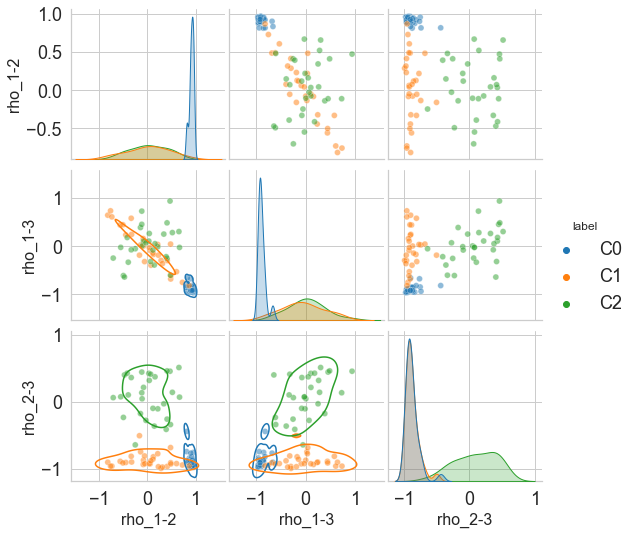

In [21]:
%%time

v_alpha = 0.5

dir_plot = f'PairPlots/Synthetic_test_Cluster_D{N_dim_true}'
os.makedirs(dir_plot, exist_ok=True)

val_s = data_Gauss_true
tmp_plot_df = []
for key, tmp_df in enumerate(val_s):
    tmp_df['label'] = f'C{key}'
    tmp_plot_df.append(deepcopy(tmp_df))
tmp_plot_df = pd.concat(tmp_plot_df, axis=0).loc[:,np.append(col_rho, 'label')]
tmp_color = sns.color_palette("tab10")[:len(val_s)]

sns.set(rc={'font.size': 8, 'axes.labelsize': 16, 'legend.fontsize': 18, 
    'axes.titlesize': 8, 'xtick.labelsize': 18, 'ytick.labelsize': 18})
sns.set_style("whitegrid") 

sns_plot = sns.pairplot(tmp_plot_df, diag_kind="kde", hue='label', 
                     palette=tmp_color, plot_kws={'alpha': v_alpha})
sns_plot.map_lower(sns.kdeplot, levels=2, color=".2")
sns_plot.savefig(f'{dir_plot}/original_train_rho.png', dpi=500)


CPU times: user 5.44 s, sys: 55 ms, total: 5.49 s
Wall time: 2.58 s


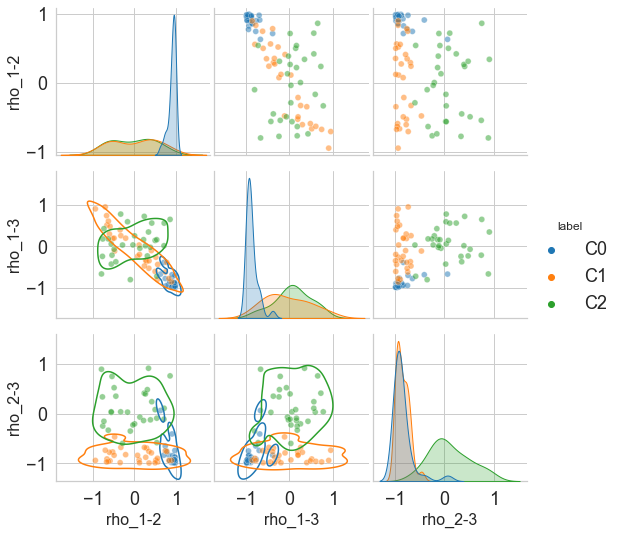

In [22]:
%%time

v_alpha = 0.5

dir_plot = f'PairPlots/Synthetic_test_Cluster_D{N_dim_true}'
os.makedirs(dir_plot, exist_ok=True)

val_s = data_Gauss_true_est
tmp_plot_df = []
for key, tmp_df in enumerate(val_s):
    tmp_df['label'] = f'C{key}'
    tmp_plot_df.append(deepcopy(tmp_df))
tmp_plot_df = pd.concat(tmp_plot_df, axis=0).loc[:,np.append(col_rho, 'label')]
tmp_color = sns.color_palette("tab10")[:len(val_s)]

sns.set(rc={'font.size': 8, 'axes.labelsize': 16, 'legend.fontsize': 18, 
    'axes.titlesize': 8, 'xtick.labelsize': 18, 'ytick.labelsize': 18})
sns.set_style("whitegrid") 

sns_plot = sns.pairplot(tmp_plot_df, diag_kind="kde", hue='label', 
                     palette=tmp_color, plot_kws={'alpha': v_alpha})
sns_plot.map_lower(sns.kdeplot, levels=2, color=".2")
sns_plot.savefig(f'{dir_plot}/original_train_est_rho.png', dpi=500)


/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  **contour_kws,
/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  **contour_kws,


CPU times: user 4.64 s, sys: 60.1 ms, total: 4.7 s
Wall time: 2.43 s


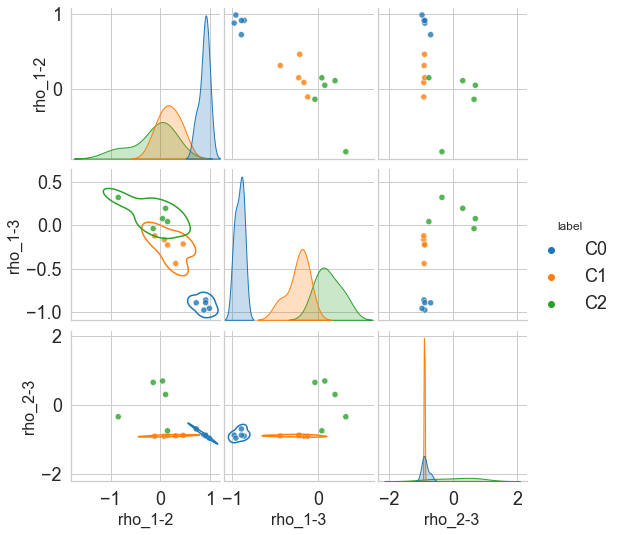

In [19]:
%%time

v_alpha = 0.8

dir_plot = f'PairPlots/Synthetic_test_Cluster_D{N_dim_true}'
os.makedirs(dir_plot, exist_ok=True)

val_s = data_Gauss_test
tmp_plot_df = []
for key, tmp_df in enumerate(val_s):
    tmp_df['label'] = f'C{key}'
    tmp_plot_df.append(deepcopy(tmp_df))
tmp_plot_df = pd.concat(tmp_plot_df, axis=0).loc[:,np.append(col_rho, 'label')]
tmp_color = sns.color_palette("tab10")[:len(val_s)]

sns.set(rc={'font.size': 8, 'axes.labelsize': 16, 'legend.fontsize': 18, 
    'axes.titlesize': 8, 'xtick.labelsize': 18, 'ytick.labelsize': 18})
sns.set_style("whitegrid") 

sns_plot = sns.pairplot(tmp_plot_df, diag_kind="kde", hue='label', 
                     palette=tmp_color, plot_kws={'alpha': v_alpha})
sns_plot.map_lower(sns.kdeplot, levels=2, color=".2")
sns_plot.savefig(f'{dir_plot}/original_test_rho.png', dpi=500)


/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  **contour_kws,
/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  **contour_kws,


CPU times: user 4.7 s, sys: 61.9 ms, total: 4.76 s
Wall time: 2.41 s


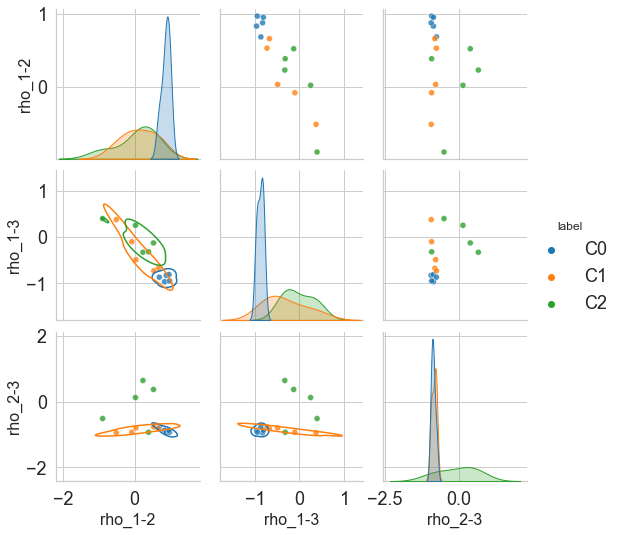

In [20]:
%%time

v_alpha = 0.8

dir_plot = f'PairPlots/Synthetic_test_Cluster_D{N_dim_true}'
os.makedirs(dir_plot, exist_ok=True)

val_s = data_Gauss_test_est
tmp_plot_df = []
for key, tmp_df in enumerate(val_s):
    tmp_df['label'] = f'C{key}'
    tmp_plot_df.append(deepcopy(tmp_df))
tmp_plot_df = pd.concat(tmp_plot_df, axis=0).loc[:,np.append(col_rho, 'label')]
tmp_color = sns.color_palette("tab10")[:len(val_s)]

sns.set(rc={'font.size': 8, 'axes.labelsize': 16, 'legend.fontsize': 18, 
    'axes.titlesize': 8, 'xtick.labelsize': 18, 'ytick.labelsize': 18})
sns.set_style("whitegrid") 

sns_plot = sns.pairplot(tmp_plot_df, diag_kind="kde", hue='label', 
                     palette=tmp_color, plot_kws={'alpha': v_alpha})
sns_plot.map_lower(sns.kdeplot, levels=2, color=".2")
sns_plot.savefig(f'{dir_plot}/original_test_est_rho.png', dpi=500)


### Clustering

Cluster with rho only

In [28]:
case_name = 'RhoOnly'

nS = 10
nC = 3
idx = 3
rand_seed = 202111
tmp_df = deepcopy(data_Gauss_true_est)

cols = [x for x in tmp_df[0].columns.values if 'rho' in x]


##### Clustering

In [29]:
%%time

tmp_df = pd.concat(tmp_df, axis=0)

np.random.seed(rand_seed)
rand_seeds = np.random.randint(0, 2**32-1, size=nS)
    
kmeans = []
tmp_df_clus = deepcopy(tmp_df)
for r_seed in rand_seeds:
    kmeans.append(KMeans(n_clusters=nC, random_state=r_seed).fit(tmp_df[cols]))

    tmp_lab = pd.DataFrame(kmeans[-1].labels_, index=tmp_df.index, columns=['kmeans'])
    tmp_lab[f'kmeans_{r_seed}'] = 0
    for ii, valK in tmp_lab['kmeans'].value_counts().reset_index()['index'].iteritems():
        tmp_lab[f'kmeans_{r_seed}'].loc[tmp_lab['kmeans'] == valK] = ii
        
    tmp_df_clus = pd.concat([tmp_df_clus, tmp_lab.loc[:,[f'kmeans_{r_seed}']]], axis=1)
    
    # sort clusters based on correlation values between x_2 and x_3
    tmp_rho = tmp_df_clus.groupby(f'kmeans_{r_seed}').mean().sort_values('rho_2-3', ascending=True).reset_index()
    tmp_map = {val: key for key, val in tmp_rho[f'kmeans_{r_seed}'].iteritems()}
    tmp_df_clus[f'kmeans_sorted_{r_seed}'] = tmp_df_clus[f'kmeans_{r_seed}'].map(tmp_map)

tmp_df_clus.to_csv(f'{dir_save_data}/Kmeans_{case_name}_K{nC}.csv')
    

/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

CPU times: user 505 ms, sys: 12.2 ms, total: 517 ms
Wall time: 511 ms


/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/miniconda3/envs/MB16_xepy37_v06_test_env/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

##### plot clusters

CPU times: user 56 s, sys: 550 ms, total: 56.5 s
Wall time: 26.5 s


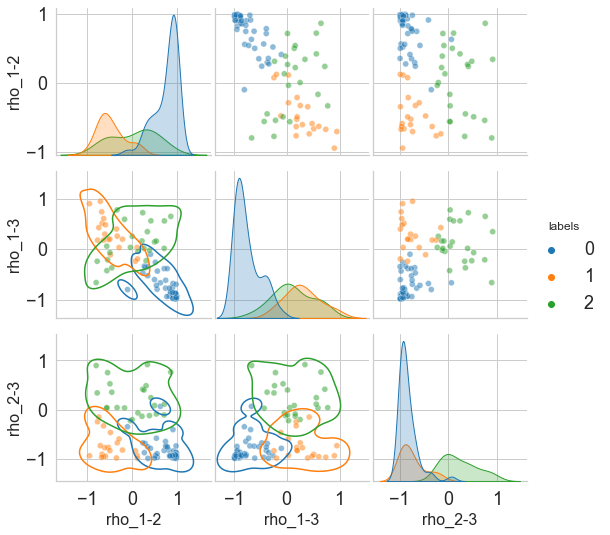

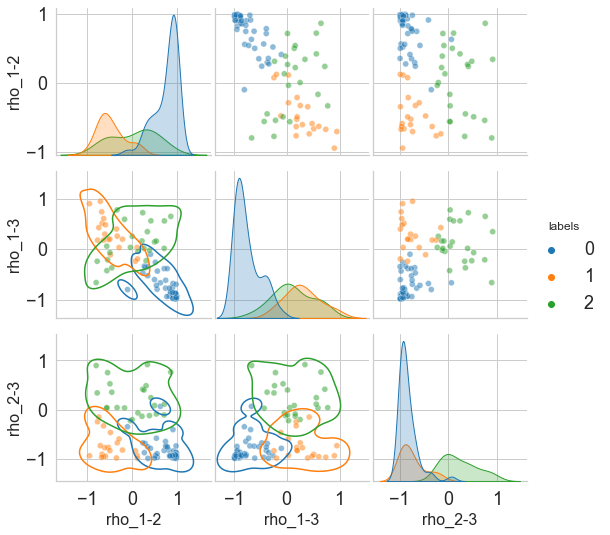

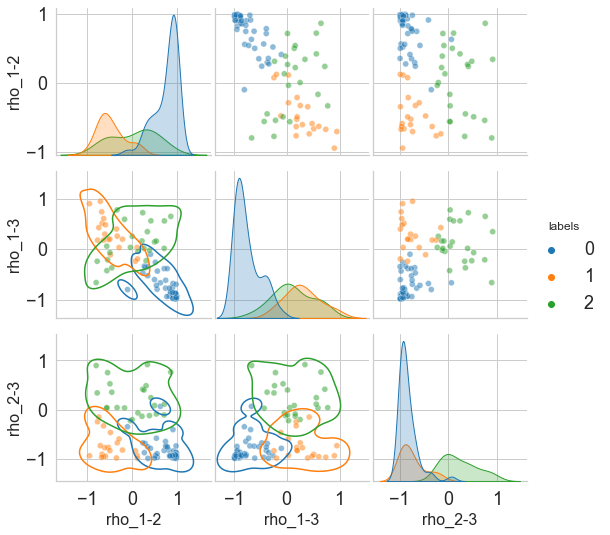

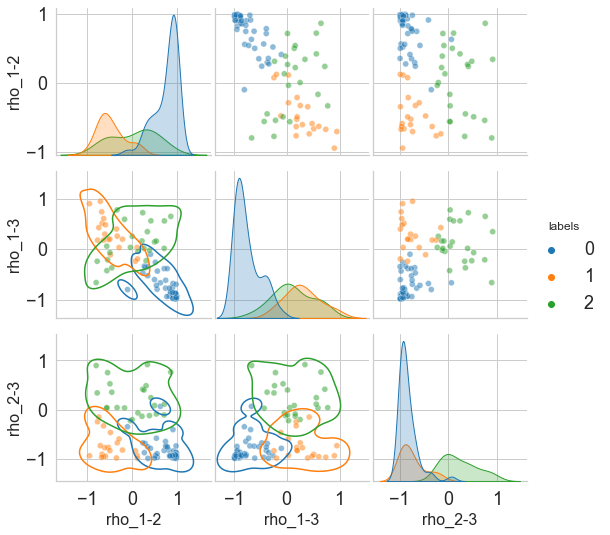

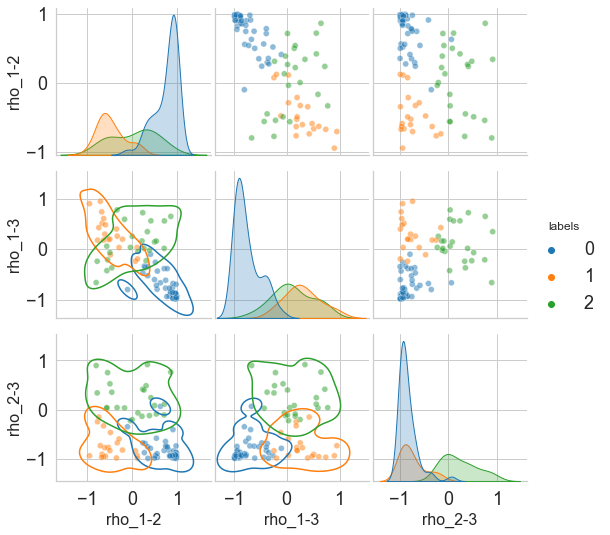

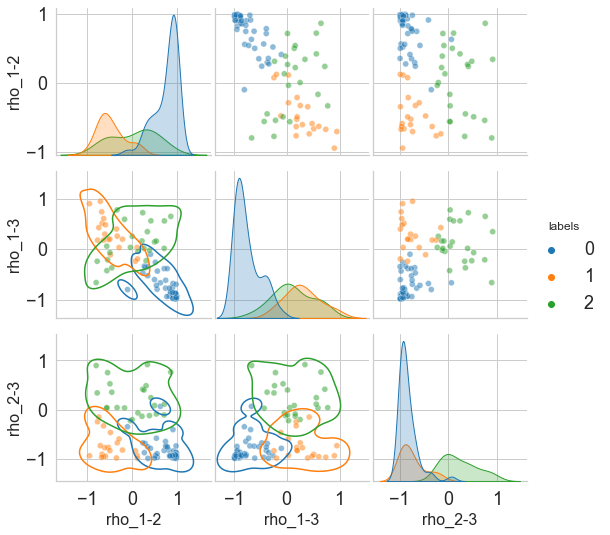

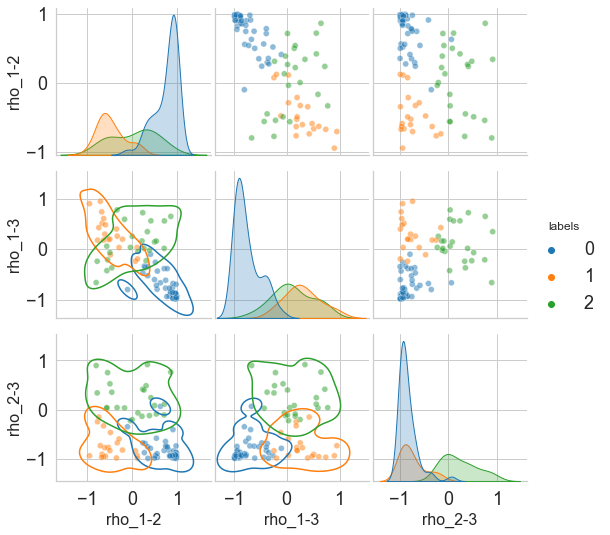

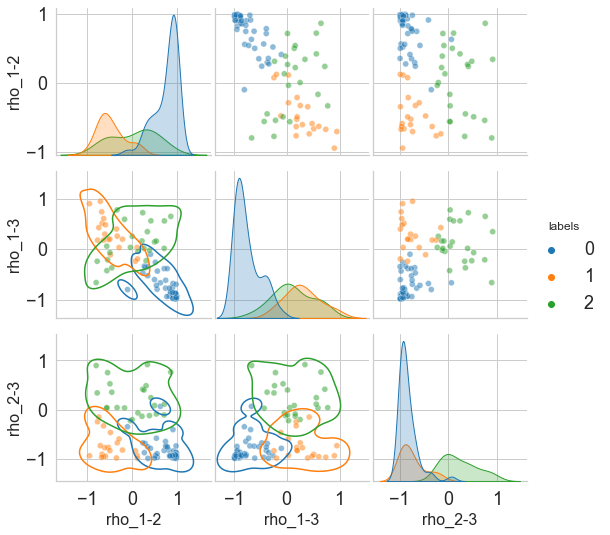

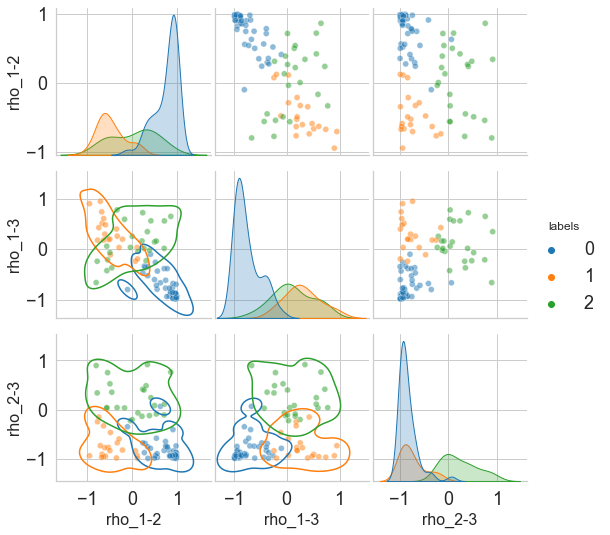

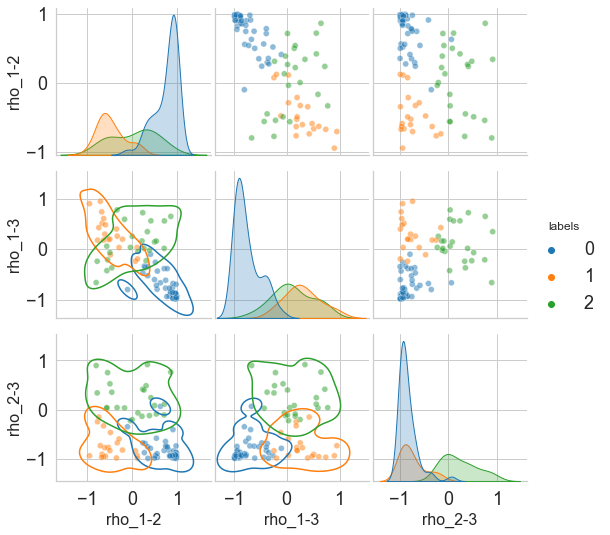

In [30]:
%%time

val_alpha = 0.5
c_list = sns.color_palette("tab10")[:nC]

dir_plot = f'PairPlots/Synthetic_test_Cluster_D{N_dim_true}/Unsupervised_clustering/{case_name}_K{nC}'
os.makedirs(dir_plot, exist_ok=True)

tmp_labs = [x for x in tmp_df_clus.columns.values if 'kmeans_sorted' in x]
tmp_cols = [x for x in tmp_df_clus.columns.values if 'rho_' in x]
for i_lab in tmp_labs:
    ii = i_lab.split('_')[-1]

    sns.set(rc={'font.size': 8, 'axes.labelsize': 16, 'legend.fontsize': 18, 
    'axes.titlesize': 8, 'xtick.labelsize': 18, 'ytick.labelsize': 18})
    sns.set_style("whitegrid")
    
    sns_plot = sns.pairplot(tmp_df_clus[tmp_cols+[i_lab]].rename({i_lab: 'labels'}, axis=1), diag_kind="kde", hue='labels', 
                     palette=c_list, plot_kws={'alpha': val_alpha})
    sns_plot.map_lower(sns.kdeplot, levels=2, color=".2")
    sns_plot.savefig(f'{dir_plot}/rho_Seed_{ii}.png', dpi=500)
    

### HBM Gibbs

In [8]:
dir_save_data = f'Data/SynData_Cluster_D{N_dim_true}_Str{rand_seed}_Ste{rand_seed_test}'

tmp_df_clus = pd.read_csv(f'{dir_save_data}/Kmeans_RhoOnly_K3.csv', index_col=0)
tmp_df_clus


,mu_1,mu_2,mu_3,sig_1,sig_2,sig_3,rho_1-2,rho_1-3,rho_2-3,label,...,kmeans_2378583522,kmeans_sorted_2378583522,kmeans_1427277360,kmeans_sorted_1427277360,kmeans_1518324557,kmeans_sorted_1518324557,kmeans_1533298048,kmeans_sorted_1533298048,kmeans_1281224253,kmeans_sorted_1281224253
1-0,1.092334,3.112657,0.805621,0.710334,0.813915,0.840653,0.898849,-0.892054,-0.983319,C0,...,0,0,0,0,0,0,0,0,0,0
1-1,-0.599434,-1.485435,1.449886,1.143928,1.267094,1.100944,0.990952,-0.939060,-0.939983,C0,...,0,0,0,0,0,0,0,0,0,0
1-2,-0.832692,-0.581666,-0.027243,1.123346,0.910414,1.035064,0.825609,-0.930441,-0.828502,C0,...,0,0,0,0,0,0,0,0,0,0
1-3,1.216533,0.219293,-1.553710,0.623929,0.689464,1.014434,0.862354,-0.866091,-0.942569,C0,...,0,0,0,0,0,0,0,0,0,0
1-4,-0.320017,1.088122,0.693713,0.624579,0.580384,0.598993,0.899947,-0.765663,-0.914448,C0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3-25,0.320104,-2.460632,0.146601,0.746275,1.589475,0.598019,0.500478,0.143164,0.081475,C2,...,1,2,1,2,1,2,1,2,1,2
3-26,0.977767,0.267352,0.661743,0.951735,1.439706,1.237967,-0.799583,-0.663120,0.892305,C2,...,1,2,1,2,1,2,1,2,1,2
3-27,1.384034,1.053733,0.028674,0.944548,1.418150,0.631645,0.863063,0.649367,0.758686,C2,...,1,2,1,2,1,2,1,2,1,2
3-28,-1.347034,1.072069,0.353668,1.660317,0.981486,0.990361,0.312044,-0.229710,0.482277,C2,...,1,2,1,2,1,2,1,2,1,2


Pick up specific cluster and prepare data for HBM-Gibbs on each cluster

In [35]:
HBM_seed = 202111
selected_seed = 6803724
col = f'kmeans_sorted_{selected_seed}'

n_repeat = 1

x_cluster = {}
for s in tmp_df_clus[col].unique():
    tmp_idx = tmp_df_clus.index[tmp_df_clus[col] == s].values
    x_cluster[s] = []
    for i1, i2 in [x.split('-') for x in tmp_idx]:
        for _ in range(n_repeat):
            x_cluster[s].append(deepcopy(x_true[int(i1)-1][int(i2)]))


Run HBM-Gibbs on each cluster to get hyperparameter samples

In [36]:
%%time

np.random.seed(HBM_seed)

mu_s, C_s, mu_0, C_0, Sig_0, nu_0, a_k = {}, {}, {}, {}, {}, {}, {}
for key, val in x_cluster.items():
        mu_s[key], C_s[key], mu_0[key], C_0[key], Sig_0[key], nu_0[key], a_k[key] = hbm_gibbs_nomissing(val)
        print(f'{key} done')
        

0 done
1 done
2 done
CPU times: user 8min 4s, sys: 860 ms, total: 8min 5s
Wall time: 8min 5s


Save results

In [37]:
with open(f'{dir_save_data}/HBM_Gibbs_Sk{selected_seed}_S{HBM_seed}_N{n_repeat}.pkl', 'wb') as f:
    pk.dump({'mu_s': mu_s, 'C_s': C_s, 'mu_0': mu_0, 'C_0': C_0, 'Sig_0': Sig_0, 'nu_0': nu_0, 'a_k': a_k}, f)
    

Re-do the process for the global case (all training sites used in HBM-Gibbs)

In [38]:
HBM_seed = 202111

x_cluster = {'All': np.concatenate(x_true)}


In [39]:
%%time

np.random.seed(HBM_seed)

mu_s, C_s, mu_0, C_0, Sig_0, nu_0, a_k = {}, {}, {}, {}, {}, {}, {}
for key, val in x_cluster.items():
        mu_s[key], C_s[key], mu_0[key], C_0[key], Sig_0[key], nu_0[key], a_k[key] = hbm_gibbs_nomissing(val)
        print(f'{key} done')
        

All done
CPU times: user 7min 17s, sys: 864 ms, total: 7min 18s
Wall time: 7min 19s


In [40]:
with open(f'{dir_save_data}/HBM_Gibbs_All_S{HBM_seed}.pkl', 'wb') as f:
    pk.dump({'mu_s': mu_s, 'C_s': C_s, 'mu_0': mu_0, 'C_0': C_0, 'Sig_0': Sig_0, 'nu_0': nu_0, 'a_k': a_k}, f)
    

##### Plot fitting

Get mu_s and C_s parameters for HBM-Clus results

In [41]:
dir_save_data = 'Data/SynData_Cluster_D3_Str202111_Ste20211100'

with open(f'{dir_save_data}/HBM_Gibbs_Sk6803724_S202111_N1.pkl', 'rb') as f:
    tmp = pk.load(f)
    
mu_s = tmp['mu_s']
C_s = tmp['C_s']
mu_0 = tmp['mu_0']
C_0 = tmp['C_0']
Sig_0 = tmp['Sig_0']
nu_0 = tmp['nu_0']
a_k = tmp['a_k']


In [42]:
%%time

N_burn = 1000
del_t = 10
N_i = 1
Nt = mu_0[list(mu_0.keys())[0]].shape[1]
N_psi = len(list(range(N_burn, Nt, del_t)))
Ndim = mu_0[list(mu_0.keys())[0]].shape[0]
rand_seed = 202111

np.random.seed(rand_seed)
rand_seeds = np.random.randint(0, 2**32-1, size=N_psi)

col_mu = [f'mu_{x}' for x in range(Ndim)]
col_sig = [f'sig_{x}' for x in range(Ndim)]
col_rho = [f'rho_{x}-{y}' for y in range(1, Ndim) for x in range(y)]

data_Gauss = {}
for key in mu_0.keys():
    if N_i == 1:
        data_Mu = np.zeros([Ndim, N_psi])
        data_Sigma = np.zeros([Ndim, Ndim, N_psi])

        for ii, iS in enumerate(range(N_burn, Nt, del_t)):
            data_Mu[:, ii] = multivariate_normal.rvs(mean=mu_0[key][:, iS], cov=C_0[key][:, :, iS], random_state=rand_seeds[ii]).T
            data_Sigma[:, :, ii] = invwishart.rvs(df=nu_0[key][iS], scale=Sig_0[key][:, :, iS], random_state=rand_seeds[ii]).T
    else:
        data_Mu = np.zeros([Ndim, N_i, N_psi])
        data_Sigma = np.zeros([Ndim, Ndim, N_i, N_psi])

        for ii, iS in enumerate(range(N_burn, Nt, del_t)):
            data_Mu[:, :, ii] = multivariate_normal.rvs(mean=mu_0[key][:, iS], cov=C_0[key][:, :, iS], size=N_i, random_state=rand_seeds[ii]).T
            data_Sigma[:, :, :, ii] = invwishart.rvs(df=nu_0[key][iS], scale=Sig_0[key][:, :, iS], size=N_i, random_state=rand_seeds[ii]).T

    mu = data_Mu[:Ndim,].reshape(Ndim,-1)
    cov = data_Sigma[:Ndim,:Ndim,].reshape(Ndim,Ndim,-1)
    sig = np.sqrt(np.diagonal(cov).T)
    rho = np.vstack([cov[y,x,:]/sig[y,:]/sig[x,:] for y in range(1, Ndim) for x in range(y)])

    data_Gauss[key] = pd.DataFrame(np.concatenate([mu, sig, rho]).T, columns=col_mu+col_sig+col_rho)
    

CPU times: user 3.82 s, sys: 57.4 ms, total: 3.87 s
Wall time: 3.88 s


Plot mu_s and C_s parameters for HBM-Clus

CPU times: user 26.9 s, sys: 152 ms, total: 27 s
Wall time: 14.6 s


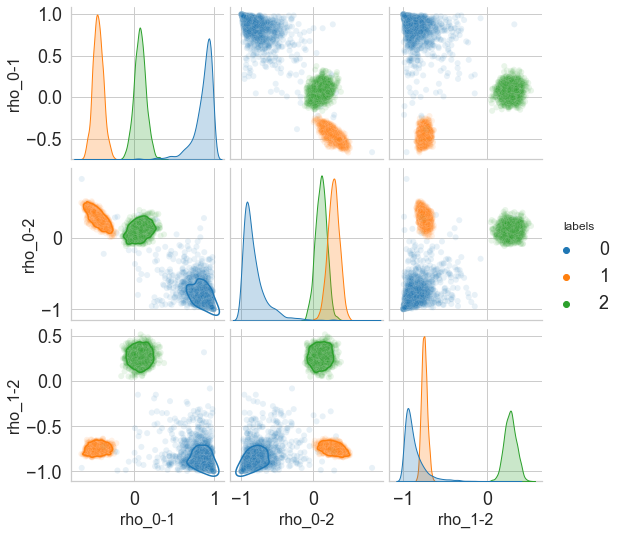

In [43]:
%%time

val_alpha = 0.1
c_list = sns.color_palette("tab10")[:nC]

dir_plot = f'PairPlots/Synthetic_test_Cluster_D{N_dim_true}/HBM_Gibbs'
os.makedirs(dir_plot, exist_ok=True)

tmp_df_clus = []
for key, val in data_Gauss.items():
    val_tmp = val.loc[:, col_rho]
    val_tmp['labels'] = key
    tmp_df_clus.append(deepcopy(val_tmp))
tmp_df_clus = pd.concat(tmp_df_clus, axis=0)
    
sns.set(rc={'font.size': 8, 'axes.labelsize': 16, 'legend.fontsize': 18, 
    'axes.titlesize': 8, 'xtick.labelsize': 18, 'ytick.labelsize': 18})
sns.set_style("whitegrid")
    
sns_plot = sns.pairplot(tmp_df_clus, diag_kind="kde", hue='labels', 
                 palette=c_list, plot_kws={'alpha': val_alpha})
sns_plot.map_lower(sns.kdeplot, levels=2, color=".2")
sns_plot.savefig(f'{dir_plot}/{case_name}_K{nC}_S{selected_seed}_N{n_repeat}.png', dpi=500)
    

Do the same for HBM-Gibbs (based on all training sites)

In [44]:
dir_save_data = 'Data/SynData_Cluster_D3_Str202111_Ste20211100'
    
with open(f'{dir_save_data}/HBM_Gibbs_All_S202111.pkl', 'rb') as f:
    tmp = pk.load(f)
    
mu_s = tmp['mu_s']
C_s = tmp['C_s']
mu_0 = tmp['mu_0']
C_0 = tmp['C_0']
Sig_0 = tmp['Sig_0']
nu_0 = tmp['nu_0']
a_k = tmp['a_k']


In [45]:
%%time

N_burn = 1000
del_t = 10
N_i = 1
Nt = mu_0[list(mu_0.keys())[0]].shape[1]
N_psi = len(list(range(N_burn, Nt, del_t)))
Ndim = mu_0[list(mu_0.keys())[0]].shape[0]
rand_seed = 202111

np.random.seed(rand_seed)
rand_seeds = np.random.randint(0, 2**32-1, size=N_psi)

col_mu = [f'mu_{x}' for x in range(Ndim)]
col_sig = [f'sig_{x}' for x in range(Ndim)]
col_rho = [f'rho_{x}-{y}' for y in range(1, Ndim) for x in range(y)]

data_Gauss = {}
for key in mu_0.keys():
    if N_i == 1:
        data_Mu = np.zeros([Ndim, N_psi])
        data_Sigma = np.zeros([Ndim, Ndim, N_psi])

        for ii, iS in enumerate(range(N_burn, Nt, del_t)):
            data_Mu[:, ii] = multivariate_normal.rvs(mean=mu_0[key][:, iS], cov=C_0[key][:, :, iS], random_state=rand_seeds[ii]).T
            data_Sigma[:, :, ii] = invwishart.rvs(df=nu_0[key][iS], scale=Sig_0[key][:, :, iS], random_state=rand_seeds[ii]).T
    else:
        data_Mu = np.zeros([Ndim, N_i, N_psi])
        data_Sigma = np.zeros([Ndim, Ndim, N_i, N_psi])

        for ii, iS in enumerate(range(N_burn, Nt, del_t)):
            data_Mu[:, :, ii] = multivariate_normal.rvs(mean=mu_0[key][:, iS], cov=C_0[key][:, :, iS], size=N_i, random_state=rand_seeds[ii]).T
            data_Sigma[:, :, :, ii] = invwishart.rvs(df=nu_0[key][iS], scale=Sig_0[key][:, :, iS], size=N_i, random_state=rand_seeds[ii]).T

    mu = data_Mu[:Ndim,].reshape(Ndim,-1)
    cov = data_Sigma[:Ndim,:Ndim,].reshape(Ndim,Ndim,-1)
    sig = np.sqrt(np.diagonal(cov).T)
    rho = np.vstack([cov[y,x,:]/sig[y,:]/sig[x,:] for y in range(1, Ndim) for x in range(y)])

    data_Gauss[key] = pd.DataFrame(np.concatenate([mu, sig, rho]).T, columns=col_mu+col_sig+col_rho)
    

CPU times: user 1.27 s, sys: 20.7 ms, total: 1.29 s
Wall time: 1.29 s


CPU times: user 8.88 s, sys: 42.7 ms, total: 8.92 s
Wall time: 4.76 s


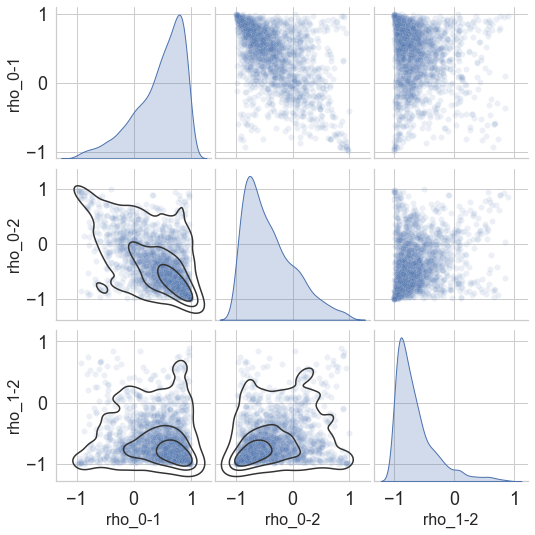

In [46]:
%%time

val_alpha = 0.1
c_list = sns.color_palette("tab10")[0:1]

dir_plot = f'PairPlots/Synthetic_test_Cluster_D{N_dim_true}/HBM_Gibbs'
os.makedirs(dir_plot, exist_ok=True)

tmp_df_clus = []
for key, val in data_Gauss.items():
    tmp_df_clus.append(deepcopy(val.loc[:, col_rho]))
tmp_df_clus = pd.concat(tmp_df_clus, axis=0)
    
sns.set(rc={'font.size': 8, 'axes.labelsize': 16, 'legend.fontsize': 18, 
    'axes.titlesize': 8, 'xtick.labelsize': 18, 'ytick.labelsize': 18})
sns.set_style("whitegrid")

sns_plot = sns.pairplot(tmp_df_clus, diag_kind="kde", plot_kws={'alpha': val_alpha})
sns_plot.map_lower(sns.kdeplot, levels=4, color=".2")
sns_plot.savefig(f'{dir_plot}/{case_name}_K{nC}_All.png', dpi=500)
    

### Prediction for test data

Load HBM samples

In [9]:
dir_load = 'Data/SynData_Cluster_D3_Str202111_Ste20211100'
f_all = 'HBM_Gibbs_All_S202111.pkl'
f_cluster = 'HBM_Gibbs_Sk6803724_S202111_N1.pkl'
# f_cluster_true = 'HBM_Gibbs_TrueCluster_S202111.pkl'

with open(f'{dir_load}/{f_all}', 'rb') as f:
    S_all = pk.load(f)
    
with open(f'{dir_load}/{f_cluster}', 'rb') as f:
    S_clus = pk.load(f)
    
# with open(f'{dir_load}/{f_cluster_true}', 'rb') as f:
#     S_clus_true = pk.load(f)
    

Generate mu_s and C_s samples from hyperparameter samples

In [10]:
%%time

N_burn = 1000
del_t = 10 # pick one for every del_t samples
N_i = 1
rand_seed = 202111

prd_hbm = {}

tmp_dict = {}
for key, val in S_all.items():
    tmp_dict[key] = val['All']
    
prd_hbm['All'] = HBM_prd(deepcopy(tmp_dict))

tmp_dict = {f'K_{key+1}': {} for key in S_clus[list(S_clus.keys())[0]].keys()}
for key, val in S_clus.items():
    for kK, vV in val.items():
        tmp_dict[f'K_{kK+1}'][key] = vV
    
for key, val in tmp_dict.items():
    prd_hbm[key] = HBM_prd(deepcopy(val))
    
# # tmp_dict = {f'true_{key}': {} for key in S_clus_true[list(S_clus_true.keys())[0]].keys()}
# # for key, val in S_clus_true.items():
# #     for kK, vV in val.items():
# #         tmp_dict[f'true_{kK}'][key] = vV
    
for key, val in tmp_dict.items():
    prd_hbm[key] = HBM_prd(deepcopy(val))
    
for key, val in prd_hbm.items():
    _ = val.gen_gauss_samples(N_burn=N_burn, del_t=del_t, N_i=N_i, rand_seed=rand_seed)
    

CPU times: user 4.81 s, sys: 133 ms, total: 4.94 s
Wall time: 4.95 s


##### Predict missing x values

Prepare test data

In [11]:
x_test_concat = []
for x in x_test:
    x_test_concat += x
    
len(x_test_concat)

15

Parameters for running the prediction for missing x_3

In [12]:
# for different test cases
miss_data_idx = [list(range(x,10,1)) for x in [0, 2, 4]]

# hyperparameter samples to be used actually (according to Ching et al. 2021)
N_burn_h=1000 # burn-in
del_t_h=10 # pick one for every del_t samples

# same set up as in Ching et al. 2021 for sampling mu_s and C_s for a new site with given incomplete data
Nt = 21 # total number of full Gibbs steps
del_t = 1 # pick one for every del_t samples
N_burn = 20 # burn-in

idx_miss_dat = 2 # correspond to x_3

rand_seed = 202111


Predicting missing x values of each test sites for each HBM of the clusters and the global case (including all training sites)

In [62]:
%%time

np.random.seed(rand_seed)
rand_seeds = np.random.randint(0, 2 ** 32 - 1, size=len(miss_data_idx))

x_miss_samples_full = []

for iD, d_idx in enumerate(miss_data_idx):
    x_S = deepcopy(x_test_concat)
    for x in x_S:
        x[d_idx, idx_miss_dat] = np.nan

    tmp_x_samples = {key: val.gen_missing_x(
            x_S=x_S, N_burn=N_burn, del_t=del_t, Nt=Nt, rand_seed=rand_seeds[iD], N_burn_h=N_burn_h, del_t_h=del_t_h
    ) for key, val in prd_hbm.items()}
    
    x_miss_samples_full.append(deepcopy(tmp_x_samples))
    
    print(f'Finished {iD}')
    

Finished 0
Finished 1
Finished 2
CPU times: user 48min 36s, sys: 4.43 s, total: 48min 41s
Wall time: 48min 42s


Save predictions

In [63]:
dir_save = 'Data/SynData_Cluster_D3_Str202111_Ste20211100'

with open(f'{dir_save}/Test_x_miss_samples_full.pkl', 'wb') as f:
    pk.dump(x_miss_samples_full, f)
    

##### Prepare weights for missing x prediction

In [13]:
dir_load = 'Data/SynData_Cluster_D3_Str202111_Ste20211100'

with open(f'{dir_load}/Test_x_miss_samples_full.pkl', 'rb') as f:
    x_miss_samples_full = pk.load(f)
    

In [15]:
site_labels = {}
for lab in x_test_df['label'].unique():
    site_labels[lab] = x_test_df.index[x_test_df['label'] == lab].values


Calculate likelihoods for weighting

In [16]:
%%time

N_site = len(x_miss_samples_full[0]['All'][0])
N_clus = len(x_miss_samples_full[0])
TF_singular = False #set to True if any case fail

site_labels

wC_logP_miss = {}
for iD, d_idx in enumerate(miss_data_idx):
    wC_logP_miss[f'{iD}data'] = pd.DataFrame(index=list(range(N_site)), columns=prd_hbm.keys(), dtype=float)
    dd_idx = [x for x in range(10) if x not in d_idx]
    
    for key_c, prd_c in prd_hbm.items():
        for iS, x_dat in enumerate(x_test_concat):
            tmp_w = []
            for mu, sig in zip(prd_c._gen_mu.T, prd_c._gen_cov.T):
                if len(dd_idx) == 1:
                    tmp1 = multivariate_normal.logpdf(x_dat[dd_idx,:], mean=mu, cov=sig, allow_singular=TF_singular)
                elif len(dd_idx) > 0:
                    tmp1 = multivariate_normal.logpdf(x_dat[dd_idx,:], mean=mu, cov=sig, allow_singular=TF_singular).sum()
                else:
                    tmp1 = 0
                tmp2 = multivariate_normal.logpdf(x_dat[d_idx,:2], mean=mu[:2], cov=sig[:2,:2], allow_singular=TF_singular).sum()
                tmp_w.append(tmp1+tmp2)

            wC_logP_miss[f'{iD}data'].loc[iS, key_c] = logsumexp(tmp_w) - np.log(len(tmp_w))
            
    wC_logP_miss[f'{iD}data'].index = site_labels.keys()


CPU times: user 57.3 s, sys: 70.3 ms, total: 57.3 s
Wall time: 57.4 s


Get normalized weight for HBM-Clus

In [17]:
df_w_miss = {}


In [18]:
tmp_lab = 'clus'
clus_labels = np.sort(list(prd_hbm.keys()))
tmp_labels = np.sort([x for x in clus_labels if 'K_' in x])
tmp_wC_logP_miss = {key: val[tmp_labels] for key, val in wC_logP_miss.items()}

df_w_miss[tmp_lab] = {}
for key, val in tmp_wC_logP_miss.items():
    df_w_miss[tmp_lab][key] = pd.DataFrame(index=val.index, columns=val.columns, dtype=float)
    for idx, vV in val.iterrows():
        df_w_miss[tmp_lab][key].loc[idx,:] = np.exp(vV - logsumexp(vV))


Get normalized weight for HBM-Clus+

In [19]:
tmp_lab = 'clus_ex'
clus_labels = np.sort(list(prd_hbm.keys()))
tmp_labels = np.sort([x for x in clus_labels if 'true_' not in x])
tmp_wC_logP_miss = {key: val[tmp_labels] for key, val in wC_logP_miss.items()}

df_w_miss[tmp_lab] = {}
for key, val in tmp_wC_logP_miss.items():
    df_w_miss[tmp_lab][key] = pd.DataFrame(index=val.index, columns=val.columns, dtype=float)
    for idx, vV in val.iterrows():
        df_w_miss[tmp_lab][key].loc[idx,:] = np.exp(vV - logsumexp(vV))


Plot weights in HBM-Clus and HBM-Clus+ over different cases

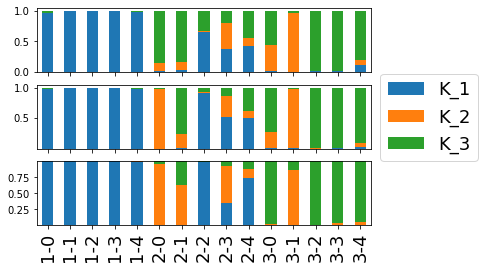

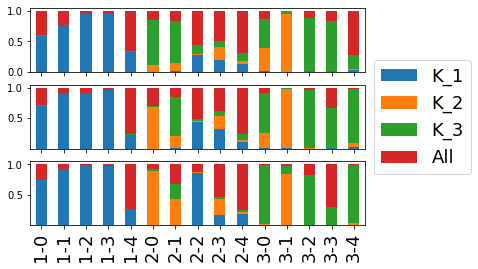

In [20]:
dir_plot = f'HBM_plots/Synthetic_test_miss_Cluster_D{N_dim_true}'
os.makedirs(dir_plot, exist_ok=True)

col_order = {'clus': ['K_1','K_2','K_3'],
             'clus_ex': ['K_1','K_2','K_3','All']}

for key_c, tmp_w_miss in df_w_miss.items():
    # Set up the matplotlib figure
    f, ax = plt.subplots(len(miss_data_idx), 1, sharex=True)

    for iC, (key, val) in enumerate(tmp_w_miss.items()):
        tmp_val = val[col_order[key_c]]
        tmp_val.index = np.sort(list(site_labels.keys()))
        _ = tmp_val.plot.bar(stacked=True, ax=ax[iC], legend=False)
#         val.index = np.sort(list(site_labels.keys()))
#         _ = val.plot.bar(stacked=True, ax=ax[iC], legend=False)

    handles, labels = ax[0].get_legend_handles_labels()
    _ =f.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=18)
    _ =plt.xticks(fontsize=18)
    f.savefig(f'{dir_plot}/Test_weights_{key_c}_barplot.png', dpi=500)


##### Metric for prediction evaluation

IMPORTANT NOTE: instead of estimating the mean and standard deviation using weighted resampling, we applied the standard formula for getting the mean and standard deviation of a Gaussian mixture to avoid the extra uncertainty from resampling because we only plot the mean and standard deviation here. For practical use, weighted resampling is needed to get the actual prediction distribution.

Combine samples for prediction mean and variance (HBM-Gibbs)

In [40]:
N_site = len(x_miss_samples_full[0]['All'][0])
case_text = [f'{x}data' for x in range(len(x_miss_samples_full))]

mu_miss_samples = {'All': [pd.DataFrame(columns=site_labels) for _ in range(len(case_text))]}
sig_miss_samples = {'All': [pd.DataFrame(columns=site_labels) for _ in range(len(case_text))]}
r2_miss_samples = {'All': pd.DataFrame(index=site_labels, columns=case_text)}
lls_miss_samples = {'All': [pd.DataFrame(columns=site_labels) for _ in range(len(case_text))]}
ll_miss_samples = {'All': pd.DataFrame(index=site_labels, columns=case_text)}
for iD, x_samples in enumerate([x['All'] for x in x_miss_samples_full]):
    for iS, iSite in enumerate(site_labels):
        tmp_data = np.array([x[iS][miss_data_idx[iD],2] for x in x_samples])
        mu_miss_samples['All'][iD][iSite] = tmp_data.mean(axis=0)
        sig_miss_samples['All'][iD][iSite] = tmp_data.std(axis=0)
        r2_miss_samples['All'].loc[iSite, f'{iD}data'] = r2_score(x_test_concat[iS][miss_data_idx[iD],2], mu_miss_samples['All'][iD][iSite].values)
        lls_miss_samples['All'][iD][iSite] = norm.logpdf(x_test_concat[iS][miss_data_idx[iD],2], mu_miss_samples['All'][iD][iSite], sig_miss_samples['All'][iD][iSite].values)
        ll_miss_samples['All'].loc[iSite, f'{iD}data'] = lls_miss_samples['All'][iD][iSite].sum()


Combine samples for prediction mean and variance (HBM-Clus and HBM-Clus+)

In [41]:
for key_c, tmp_w_miss in df_w_miss.items():
    mu_miss_samples[key_c] = [pd.DataFrame(columns=tmp_w_miss[list(tmp_w_miss.keys())[0]].index) for _ in range(len(tmp_w_miss))]
    sig_miss_samples[key_c] = [pd.DataFrame(columns=tmp_w_miss[list(tmp_w_miss.keys())[0]].index) for _ in range(len(tmp_w_miss))]
    r2_miss_samples[key_c] = pd.DataFrame(index=tmp_w_miss[list(tmp_w_miss.keys())[0]].index, columns=tmp_w_miss.keys())
    lls_miss_samples[key_c] = [pd.DataFrame(columns=tmp_w_miss[list(tmp_w_miss.keys())[0]].index) for _ in range(len(tmp_w_miss))]
    ll_miss_samples[key_c] = pd.DataFrame(index=tmp_w_miss[list(tmp_w_miss.keys())[0]].index, columns=tmp_w_miss.keys())
    
    for iD, x_samples in enumerate(x_miss_samples_full):
        tmp_samples = [x_samples[x] for x in tmp_w_miss[f'{iD}data'].columns]
        for iS, (iSite, tmp_w) in enumerate(tmp_w_miss[f'{iD}data'].iterrows()):
            tmp_data = np.array([[x[iS][miss_data_idx[iD],2] for x in x_clus] for x_clus in tmp_samples])
            mu_miss_samples[key_c][iD][iSite] = np.matmul(tmp_w.values, tmp_data.mean(axis=1))
            sig_miss_samples[key_c][iD][iSite] = np.sqrt(np.matmul(
                tmp_w.values, tmp_data.var(axis=1) + (tmp_data.mean(axis=1)**2)) - mu_miss_samples[key_c][iD][iSite].values**2)
            r2_miss_samples[key_c].loc[iSite, f'{iD}data'] = r2_score(x_test_concat[iS][miss_data_idx[iD],2], mu_miss_samples[key_c][iD][iSite].values)
            lls_miss_samples[key_c][iD][iSite] = norm.logpdf(x_test_concat[iS][miss_data_idx[iD],2], mu_miss_samples[key_c][iD][iSite], sig_miss_samples[key_c][iD][iSite].values)
            ll_miss_samples[key_c].loc[iSite, f'{iD}data'] = lls_miss_samples[key_c][iD][iSite].sum()


Plot results of likelihood difference

In [42]:
ll_miss_samples_diff = {
    'K3': ll_miss_samples['clus'] - ll_miss_samples['All'],
    'K3+': ll_miss_samples['clus_ex'] - ll_miss_samples['All']
}

<Figure size 576x360 with 0 Axes>

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

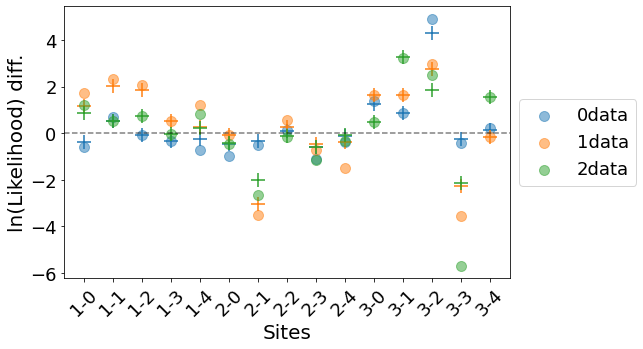

In [55]:
dir_plot = f'HBM_plots/Synthetic_test_miss_Cluster_D{N_dim_true}'
os.makedirs(dir_plot, exist_ok=True)

dot_size = 100
tmp_df = deepcopy(ll_miss_samples_diff)

col_list = tmp_df[list(tmp_df.keys())[0]].columns
x_list = tmp_df[list(tmp_df.keys())[0]].index.values
c_list = sns.color_palette("tab10")[:len(col_list)]

plt.figure(figsize=(8,5))
for ii, col in enumerate(col_list):
    _ = plt.scatter(x_list, tmp_df['K3'][col].values, s=dot_size, c=c_list[ii], alpha=0.5)
    _ = plt.scatter(x_list, tmp_df['K3+'][col].values, s=dot_size*2, c=c_list[ii], marker = '+')
    _ = plt.scatter([], [], s=dot_size, c=c_list[ii], alpha=0.5, label=col)
    
_ =plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
_ =plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
_ =plt.xticks(fontsize=18, rotation=45)
_ =plt.yticks(fontsize=18)
_ =plt.xlabel('Sites', fontsize=20)
_ =plt.ylabel('ln(Likelihood) diff.', fontsize=20)
_ =plt.savefig(f'{dir_plot}/Test_logLL_compare.png', dpi=500)


Plot data and prediction for a specific test site

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

CPU times: user 1.24 s, sys: 55.3 ms, total: 1.29 s
Wall time: 1.29 s


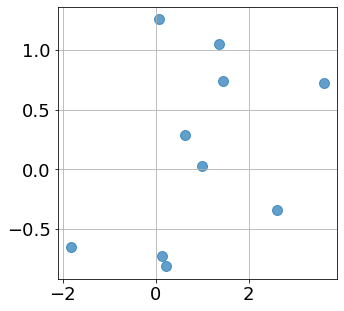

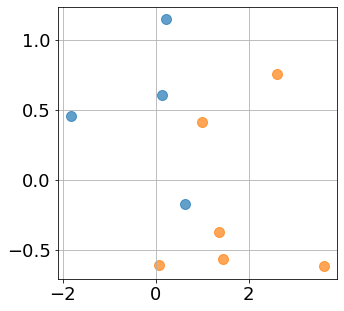

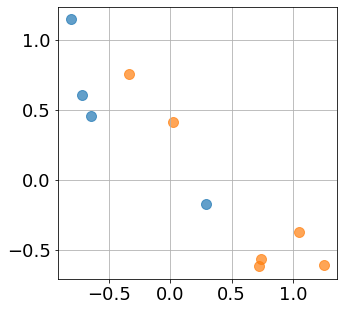

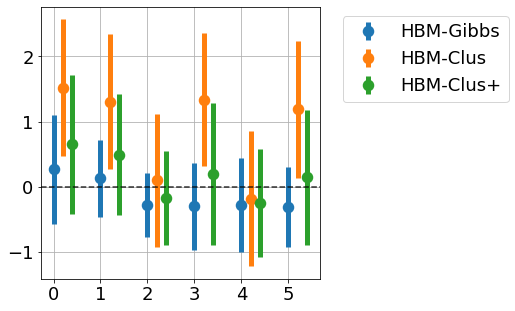

In [106]:
%%time

iCase = 2
iSite = '3-3'

c_list = sns.color_palette("tab10")[:3]
dot_size = 100

dir_plot = f'HBM_plots/Synthetic_test_miss_Cluster_D3/Sites_{iSite}'
os.makedirs(dir_plot, exist_ok=True)

x_vec = x_test_df.loc[x_test_df['label'] == iSite,:].drop('label', axis=1).values

# plot data points
for i1, x_L in enumerate(x_vec[:,:-1].T):
    for i2, y_L in enumerate(x_vec[:,(i1+1):].T):
        plt.figure(figsize=(5,5))
        if (i1 == 0) and (i2 == 0):
            _ = plt.scatter(x_L, y_L, s=dot_size, c=c_list[0], alpha=0.7)
        else:
            _ = plt.scatter(x_L[miss_data_idx[iCase]], y_L[miss_data_idx[iCase]], s=dot_size, c=c_list[1], alpha=0.7)
            _ = plt.scatter(np.delete(x_L, miss_data_idx[iCase]), np.delete(y_L, miss_data_idx[iCase]), s=dot_size, c=c_list[0], alpha=0.7)
#         plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1))
        _ = plt.xticks(fontsize= 18)
        _ = plt.yticks(fontsize= 18)
        _ = plt.grid()
        plt.savefig(f'{dir_plot}/x{i1}_x{i2+i1+1}_Case{iCase}.png', dpi=500)

# plot prediction comparison
x_vec = x_vec[miss_data_idx[iCase],2]
mu_all, sig_all = mu_miss_samples['All'][iCase][iSite] - x_vec, sig_miss_samples['All'][iCase][iSite]
mu_clus, sig_clus = mu_miss_samples['clus'][iCase][iSite] - x_vec, sig_miss_samples['clus'][iCase][iSite]
mu_clus_ex, sig_clus_ex = mu_miss_samples['clus_ex'][iCase][iSite] - x_vec, sig_miss_samples['clus_ex'][iCase][iSite]
xy_max = max((mu_all + sig_all).max(), (mu_clus + sig_clus).max(), (mu_clus_ex + sig_clus_ex).max(), x_vec.max())
xy_min = min((mu_all - sig_all).min(), (mu_clus - sig_clus).min(), (mu_clus_ex - sig_clus_ex).min(), x_vec.min())
xy_del = xy_max - xy_min

_ = plt.figure(figsize=(5,5))
_ = plt.errorbar(np.arange(len(x_vec)), mu_all.values, yerr=sig_all.values, fmt='o', c=c_list[0], lw=5, mew=1.5, ms=10, label='HBM-Gibbs')
_ = plt.errorbar(np.arange(len(x_vec))+0.2, mu_clus.values, yerr=sig_clus.values, fmt='o', c=c_list[1], lw=5, mew=1.5, ms=10, label='HBM-Clus')
_ = plt.errorbar(np.arange(len(x_vec))+0.4, mu_clus_ex.values, yerr=sig_clus_ex.values, fmt='o', c=c_list[2], lw=5, mew=1.5, ms=10, label='HBM-Clus+')
_ = plt.axhline(y=0, color='k', linestyle='--', alpha=0.8)
_ = plt.xticks(np.arange(len(x_vec)), fontsize=18)
_ = plt.yticks(fontsize=18)
_ = plt.grid()
_ = plt.legend(fontsize=18, bbox_to_anchor=(1.05, 1))
_ = plt.savefig(f'{dir_plot}/Prd_Case{iCase}.png', dpi=500, bbox_inches="tight")
